# Import dependencies

In [92]:
import pandas as pd
from sqlalchemy import create_engine, func,inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import and_
import datetime as dt
from datetime import datetime, timedelta


import matplotlib.pyplot as plt



# Connect to database

In [6]:
# Connect to sqlite database using SQLAlchemy ORM
path="sqlite:///Resources/hawaii.sqlite"
engine=create_engine(path)
Base=automap_base()
Base.prepare(engine,reflect=True)
#get the classes
Base.classes.keys()


['measurement', 'station']

In [7]:
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
session=Session(engine)

## Temperature Analysis II

In [9]:
def calc_temps(start_date, end_date):
    avg_temp=session.query(func.avg(Measurement.tobs)).filter(Measurement.date>=start_date,Measurement.date<=end_date).all()
    lowest=session.query(Measurement.tobs).filter(Measurement.date>=start_date,Measurement.date<=end_date)\
    .order_by(Measurement.tobs).first()
    highest=session.query(Measurement.tobs).filter(Measurement.date>=start_date,Measurement.date<=end_date)\
    .order_by((Measurement.tobs).desc()).first()
    return(avg_temp[0][0], lowest[0],highest[0])
                

In [10]:
# Using your function, calculate the min, avg, and max for the matching dates
# from the previous year
calc_temps('2017-08-01','2017-08-07')


(79.25, 72.0, 83.0)

## Daily Rainfall Average

In [12]:
# Query rainfall per weather station for previous year, sorted by precipitation
# Include station, name, latitude, longitude, and elevation
start_date = '2012-01-01'
end_date = '2012-01-07'
session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.avg(Measurement.prcp))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >=start_date,Measurement.date<=end_date).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()



[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.03571428571428571),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.008571428571428572),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.051666666666666666),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1)]

In [21]:
#Calculate the daily normals across all weather stations for all previous years with matching month and day 
#for your trip (August first to August seventh, inclusive).
#Normals are the averages for the min, avg, and max temperatures.
norm_avg=session.query(func.avg(Measurement.tobs)).filter(Measurement.date>='2012-01-01',Measurement.date<='2012-01-01').all()
norm_min=session.query(Measurement.tobs).filter(Measurement.date>='2012-01-01',Measurement.date<='2012-01-01').order_by(Measurement.tobs).first()
norm_max=session.query(Measurement.tobs).filter(Measurement.date>='2012-01-01',Measurement.date<='2012-01-01')\
.order_by(Measurement.tobs.desc()).first()
print(norm_avg[0],norm_min,norm_max)

(68.42857142857143,) (63.0,) (71.0,)


## Daily Temperature Normals

In [69]:
def daily_normals(date):
    norm_avg=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m-%d",Measurement.date)==date).all()
    min_avg=session.query(Measurement.tobs).filter(func.strftime("%m-%d",Measurement.date)==date).order_by(Measurement.tobs).first()
    max_avg=session.query(Measurement.tobs).filter(func.strftime("%m-%d",Measurement.date)==date).order_by(Measurement.tobs.desc()).first()
    c=norm_avg[0][0],min_avg[0],max_avg[0]
    return(c)


In [70]:
daily_normals('08-25')

(76.96078431372548, 69.0, 82.0)

In [102]:
# Calculate the daily normals for each day of your trip (inclusive)

start_date = '2017-08-01'
end_date = '2017-08-07'
#DECLARE @Counter INT 
list_normals=[]
date='08-01'
for x in range(7):
    
    c=daily_normals(date)
    date = (datetime.strptime(date, '%m-%d') + timedelta(days=1)).strftime('%m-%d')
    
    list_normals.append(c)
    
    
print(list_normals)    


08-01
08-02
08-03
08-04
08-05
08-06
08-07
[(75.54, 67.0, 83.0), (75.60377358490567, 68.0, 84.0), (76.61111111111111, 70.0, 85.0), (76.71153846153847, 69.0, 84.0), (76.14814814814815, 69.0, 82.0), (76.25, 67.0, 83.0), (77.15686274509804, 71.0, 83.0)]


In [96]:
df=pd.DataFrame(list_normals, columns=['avg','min','max'])
df.head()

,avg,min,max
0,75.540000,67.0,83.0
1,75.603774,68.0,84.0
2,76.611111,70.0,85.0
3,76.711538,69.0,84.0
4,76.148148,69.0,82.0


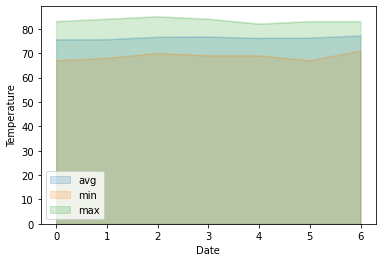

In [103]:
# Plot the daily normals as an area plot with `stacked=False`
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.savefig("images-sol/normals.png")
